In [17]:
# %% [markdown]
# # **SFO 프로젝트: 플라스틱 사출성형 제품 수요 예측 모델 개발 (자동차 데이터 제외 버전)**
#
# ## 0. 환경 설정 및 라이브러리 임포트

# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna
import shap # SHAP 분석을 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 디스플레이 설정 (데이터프레임 전체 컬럼 및 내용 확인용)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)

# matplotlib 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 기준
plt.rcParams['axes.unicode_minus'] = False # 음수 부호 깨짐 방지

print("--- [환경 설정 및 라이브러리 임포트 완료] ---")

--- [환경 설정 및 라이브러리 임포트 완료] ---


In [18]:
# %% [markdown]
# ## 1. 데이터 로드 및 수동 피처 엔지니어링
# - 원본 데이터를 로드하고, 날짜/시간 기반 피처, Lag/Rolling Mean 피처, 범주형 인코딩 등을 수행합니다.
# - **(주의: 자동차 산업 데이터 통합 부분은 이 코드에서 제외됩니다.)**

# %%
print("\n--- [1. 데이터 로드 및 수동 피처 엔지니어링 시작] ---")

# --- 1.1 데이터 로드 ---
# --- [수정 필요] 원본 데이터 파일 경로를 사용자님의 실제 경로로 바꿔주세요 ---
raw_data_path = r"C:\career\test_kmat\test\3. 사출성형 공급망최적화 AI 데이터셋.csv" # 예시 경로
# --- [수정 필요] ---

df = None
try:
    if os.path.exists(raw_data_path):
        df = pd.read_csv(raw_data_path)
        print(f"1.1 원본 데이터 로드 완료 (shape: {df.shape})")
        print("   컬럼: ", df.columns.tolist())
        print(df.head())
    else:
        raise FileNotFoundError(f"'{raw_data_path}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"🚨 원본 데이터 로드 중 오류: {e}")

if df is None:
    print("🚨 원본 데이터 로드에 실패하여 다음 단계로 진행할 수 없습니다.")
else:
    df_manual_features = df.copy() # 피처 엔지니어링을 위한 복사본 생성

    # --- [KeyError: 'Date' 해결을 위한 수정] ---
    # 원본 날짜 컬럼 이름을 'Date'로 변경
    # 'DateTime' 컬럼을 'Date'로 변경
    # --- [확인 필요] 원본 날짜 컬럼 이름이 'DateTime'이 맞는지 다시 한번 확인해주세요 ---
    if 'DateTime' in df_manual_features.columns:
        df_manual_features.rename(columns={'DateTime': 'Date'}, inplace=True)
        print("\n1.2 원본 날짜 컬럼 이름을 'Date'로 변경 완료.")
    else:
        print("\n1.2 'DateTime' 컬럼이 없어 'Date'로 변경할 수 없습니다. 'Date' 컬럼이 이미 존재하거나 다른 이름일 수 있습니다.")
        if 'Date' not in df_manual_features.columns:
             print("🚨 'Date' 컬럼이 존재하지 않습니다. 원본 데이터의 날짜/시간 컬럼명을 확인하고 코드를 수정해주세요.")
             final_df_for_tuning = None
             # return # Jupyter/Colab 환경에서는 return 대신 메시지 출력 후 다음 셀로 넘어갈 수 있도록
             # 다음 셀에서 final_df_for_tuning is None 체크하여 실행 방지

    # 'Date' 컬럼을 datetime 타입으로 변환 (다양한 형식 처리 및 오류 무시)
    # 이제 'Date' 컬럼이 존재한다는 가정 하에 진행
    if 'Date' in df_manual_features.columns: # 'Date' 컬럼이 있는 경우에만 처리
        df_manual_features['Date'] = pd.to_datetime(df_manual_features['Date'], format='mixed', errors='coerce')

        # 변환 실패한 (NaT가 된) 행이 있다면 제거 또는 처리 필요 (여기서는 제거)
        initial_rows_after_datetime = len(df_manual_features)
        df_manual_features.dropna(subset=['Date'], inplace=True)
        removed_rows_datetime_error = initial_rows_after_datetime - len(df_manual_features)
        if removed_rows_datetime_error > 0:
            print(f"   ⚠️ 날짜/시간 변환 실패로 인해 {removed_rows_datetime_error}개 행이 제거되었습니다. 원본 데이터의 'DateTime' 컬럼 형식을 확인해주세요.")
        print("1.3 'Date' 컬럼 datetime 변환 완료 (혼합 형식 처리).")
    else:
        print("🚨 'Date' 컬럼이 없어 datetime 변환을 건너뛰었습니다. 데이터를 확인해주세요.")
        final_df_for_tuning = None # Date 컬럼이 없으면 다음 단계 진행 불가
        # return

    # --- [ValueError: DoW: object 오류 해결을 위한 수정] ---
    # 만약 'DoW' 컬럼이 문자열(object) 타입이고 모델 학습에 필요 없는 경우 제거
    if 'DoW' in df_manual_features.columns and df_manual_features['DoW'].dtype == 'object':
        df_manual_features.drop('DoW', axis=1, inplace=True)
        print("1.3.1 'DoW' (object 타입) 컬럼 제거 완료.")
    elif 'DoW' in df_manual_features.columns:
        print("1.3.1 'DoW' 컬럼이 있지만 object 타입이 아니거나 이미 처리되었습니다.")

    # --- 1.4 시간 기반 피처 생성 ---
    if 'Date' in df_manual_features.columns: # Date 컬럼이 있어야 시간 기반 피처 생성 가능
        df_manual_features['Year'] = df_manual_features['Date'].dt.year
        df_manual_features['Month'] = df_manual_features['Date'].dt.month
        df_manual_features['Day'] = df_manual_features['Date'].dt.day
        df_manual_features['DayOfWeek'] = df_manual_features['Date'].dt.dayofweek # 월=0, 일=6
        df_manual_features['DayOfYear'] = df_manual_features['Date'].dt.dayofyear
        df_manual_features['WeekOfYear'] = df_manual_features['Date'].dt.isocalendar().week.astype(int)
        
        # 주말 여부 (0:평일, 1:주말)
        df_manual_features['Is_Weekend'] = (df_manual_features['DayOfWeek'] >= 5).astype(int)
        # 공휴일 여부 (데이터에 없는 경우 모두 0으로 가정. 실제 공휴일 데이터가 있다면 병합 필요)
        df_manual_features['Is_Holiday'] = 0 # 임시로 모두 0으로 설정. 실제 데이터 있다면 업데이트 필요

        print("1.4 시간 기반 피처 생성 완료.")
    else:
        print("🚨 'Date' 컬럼이 없어 시간 기반 피처 생성을 건너뛰었습니다.")
        final_df_for_tuning = None # Date 컬럼이 없으면 다음 단계 진행 불가
        # return


    # --- 1.5 Lag 및 Rolling Mean 피처 생성 (제품별로 적용) ---
    # 데이터 정렬 필수: Product_Number, Date 순으로
    if 'Product_Number' in df_manual_features.columns and 'Date' in df_manual_features.columns:
        df_manual_features = df_manual_features.sort_values(by=['Product_Number', 'Date']).reset_index(drop=True)

        # 타겟 변수 (예상 수주량)
        target_col = 'T일 예정 수주량'

        # Lag 피처 (1, 7, 30일 전 수주량)
        for lag in [1, 7, 30]:
            df_manual_features[f'lag_{lag}_수주량'] = df_manual_features.groupby('Product_Number')[target_col].shift(lag)

        # Rolling Mean 피처 (3, 7, 30일 이동평균 수주량)
        for window in [3, 7, 30]:
            df_manual_features[f'rolling_mean_{window}_수주량'] = df_manual_features.groupby('Product_Number')[target_col].rolling(window=window).mean().reset_index(level=0, drop=True)
            # Shift를 적용하여 미래 데이터 유출 방지 (현재 시점에서는 과거 윈도우 평균만 사용)
            df_manual_features[f'rolling_mean_{window}_수주량'] = df_manual_features.groupby('Product_Number')[f'rolling_mean_{window}_수주량'].shift(1)

        print("1.5 Lag 및 Rolling Mean 피처 생성 완료.")
    else:
        print("🚨 'Product_Number' 또는 'Date' 컬럼이 없어 Lag/Rolling Mean 피처 생성을 건너뛰었습니다.")
        final_df_for_tuning = None # 이 피처들이 없으면 모델 학습에 큰 영향

    # --- 1.6 범주형 변수 One-Hot Encoding ---
    if 'Product_Number' in df_manual_features.columns:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        product_encoded = ohe.fit_transform(df_manual_features[['Product_Number']])
        product_categories = ohe.get_feature_names_out(['Product_Number'])
        df_product_encoded = pd.DataFrame(product_encoded, columns=product_categories, index=df_manual_features.index)

        df_manual_features_encoded = pd.concat([df_manual_features, df_product_encoded], axis=1)
        df_manual_features_encoded = df_manual_features_encoded.drop('Product_Number', axis=1)
        print("1.6 'Product_Number' One-Hot Encoding 완료.")
    else:
        print("🚨 'Product_Number' 컬럼이 없어 One-Hot Encoding을 건너뛰었습니다.")
        df_manual_features_encoded = df_manual_features.copy() # One-Hot Encoding 없이 진행
        # final_df_for_tuning = None # 필요에 따라 다음 단계 진행 여부 결정

    # --- 1.7 결측치 처리 (Lag/Rolling Mean 등으로 발생한 NaN 제거) ---
    if df_manual_features_encoded is not None:
        initial_rows = len(df_manual_features_encoded)
        df_manual_features_encoded.dropna(inplace=True)
        removed_rows = initial_rows - len(df_manual_features_encoded)
        print(f"1.7 피처 생성 후 발생한 결측치 {removed_rows}개 행 제거 완료.")

        # 최종 데이터셋으로 Optuna에 직접 전달
        final_df_for_tuning = df_manual_features_encoded.copy()
        print(f"\n✅ 수동 피처 엔지니어링 완료! (df_manual_features_encoded shape: {final_df_for_tuning.shape})")
        print("\n[생성된 피처 확인]:")
        print(final_df_for_tuning.head())
    else:
        print("\n🚨 피처 엔지니어링 과정에서 오류가 발생하여 최종 데이터셋을 생성할 수 없습니다.")
        final_df_for_tuning = None



--- [1. 데이터 로드 및 수동 피처 엔지니어링 시작] ---
1.1 원본 데이터 로드 완료 (shape: (34617, 20))
   컬럼:  ['Product_Number', 'T일 예정 수주량', 'T+1일 예정 수주량', 'T+2일 예정 수주량', 'T+3일 예정 수주량', 'T+4일 예정 수주량', '작년 T일 예정 수주량', '작년 T+1일 예정 수주량', '작년 T+2일 예정 수주량', '작년 T+3일 예정 수주량', '작년 T+4일 예정 수주량', 'T일 예상 수주량', 'T+1일 예상 수주량', 'T+2일 예상 수주량', 'T+3일 예상 수주량', 'T+4일 예상 수주량', 'DateTime', 'DoW', 'Temperature', 'Humidity']
  Product_Number  T일 예정 수주량  T+1일 예정 수주량  T+2일 예정 수주량  T+3일 예정 수주량  T+4일 예정 수주량  작년 T일 예정 수주량  작년 T+1일 예정 수주량  작년 T+2일 예정 수주량  작년 T+3일 예정 수주량  작년 T+4일 예정 수주량  T일 예상 수주량  T+1일 예상 수주량  T+2일 예상 수주량  T+3일 예상 수주량  T+4일 예상 수주량          DateTime       DoW  Temperature   Humidity
0     Product_ac          0            0            0            2            3             7               3               0               2               0          0            8            6            0            0   2022-03-13 7:04    Sunday    20.767619  50.015714
1     Product_c2        166          130          130          130     

In [19]:
# %% [markdown]
# ## 2. Optuna를 활용한 LightGBM 모델 하이퍼파라미터 튜닝 및 평가
# - 수동 피처 엔지니어링이 적용된 데이터셋을 로드합니다.
# - 시계열 데이터 분할 (`X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`)을 수행합니다.
# - Optuna를 사용하여 LightGBM 모델의 최적 하이퍼파라미터를 탐색하고 최종 성능을 평가합니다.

# %%
print("\n--- [2. Optuna를 활용한 LightGBM 하이퍼파라미터 튜닝 시작] ---")

target = 'T일 예정 수주량' # Target 변수 정의

if final_df_for_tuning is None:
    print("🚨 최종 데이터셋 로드에 실패하여 튜닝을 진행할 수 없습니다.")
else:
    # --- 2.1 데이터 분할 (시계열 데이터이므로 시간 순서대로) ---
    print("\n2.1 시계열 데이터 분할 시작...")
    
    # 데이터를 시간 순서대로 정렬
    final_df_for_tuning = final_df_for_tuning.sort_values(by='Date').reset_index(drop=True)

    # 피처(X)와 타겟(y) 분리
    # 'Time' 컬럼은 더 이상 필요 없으며, 'Date' 컬럼은 datetime으로 사용
    exclude_cols = ['Date', target] # 'Time' 컬럼을 여기서 제외 (없을 수도 있음)
    features = [col for col in final_df_for_tuning.columns if col not in exclude_cols]

    # LightGBM은 범주형 피처를 직접 처리할 수 있으나, 여기서는 One-Hot Encoding된 상태이므로 모두 숫자형으로 간주
    # 혹시 모를 object 타입 피처를 다시 한 번 확인하고 제외
    X = final_df_for_tuning[features]
    object_cols_in_X = X.select_dtypes(include='object').columns
    if len(object_cols_in_X) > 0:
        print(f"   ⚠️ LightGBM 학습 전 {len(object_cols_in_X)}개의 object 타입 피처({', '.join(object_cols_in_X)})를 제거합니다.")
        X = X.drop(columns=object_cols_in_X)
        features = X.columns.tolist() # 피처 목록 업데이트

    y = final_df_for_tuning[target]

    # 훈련, 검증, 테스트 세트 분할 (예: 70% 훈련, 15% 검증, 15% 테스트)
    train_size = int(len(final_df_for_tuning) * 0.7)
    val_size = int(len(final_df_for_tuning) * 0.15)
    
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size : train_size + val_size], y.iloc[train_size : train_size + val_size]
    X_test, y_test = X.iloc[train_size + val_size :], y.iloc[train_size + val_size :]

    print(f"   - 훈련 세트: {X_train.shape[0]}개 (날짜 범위: {final_df_for_tuning['Date'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {final_df_for_tuning['Date'].iloc[train_size-1].strftime('%Y-%m-%d %H:%M:%S')})")
    print(f"   - 검증 세트: {X_val.shape[0]}개 (날짜 범위: {final_df_for_tuning['Date'].iloc[train_size].strftime('%Y-%m-%d %H:%M:%S')} ~ {final_df_for_tuning['Date'].iloc[train_size+val_size-1].strftime('%Y-%m-%d %H:%M:%S')})")
    print(f"   - 테스트 세트: {X_test.shape[0]}개 (날짜 범위: {final_df_for_tuning['Date'].iloc[train_size+val_size].strftime('%Y-%m-%d %H:%M:%S')} ~ {final_df_for_tuning['Date'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')})")

    # --- 2.2 Optuna Objective 함수 정의 ---
    def objective(trial):
        params = {
            'objective': 'regression_l1', # MAE를 직접 최적화 (L1 Loss)
            'metric': 'mae',
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.1),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1, # 학습 과정 메시지 출력 안 함
        }

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)]) # 검증 세트 성능 100회 동안 개선 없으면 중단

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        return mae

    # --- 2.3 Optuna Study 실행 ---
    print("\n2.2 Optuna Study 실행 중 (최적 하이퍼파라미터 탐색)...")
    study = optuna.create_study(direction='minimize', study_name='lgbm_mae_optimization_no_auto')
    study.optimize(objective, n_trials=50) # 예시로 50회 시도. 실제는 더 늘리는 것을 권장 (100~500회)

    print("\n--- Optuna 튜닝 완료 ---")
    print(f"최적 MAE (검증 세트): {study.best_value:.4f}")
    print("최적 하이퍼파라미터:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # --- 2.4 최적 모델로 최종 평가 ---
    print("\n2.3 최적 모델로 테스트 세트 최종 평가 시작...")
    best_params = study.best_params.copy()
    best_params['objective'] = 'regression_l1'
    best_params['metric'] = 'mae'
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1
    best_params['verbose'] = -1

    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val])) # 훈련 + 검증 데이터로 최종 학습

    y_test_pred = final_model.predict(X_test)
    final_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n✅ 최종 테스트 세트 MAE: {final_mae:.4f}")
    print("--- [Optuna 튜닝 및 최종 평가 완료] ---")

[I 2025-10-29 15:25:13,300] A new study created in memory with name: lgbm_mae_optimization_no_auto



--- [2. Optuna를 활용한 LightGBM 하이퍼파라미터 튜닝 시작] ---

2.1 시계열 데이터 분할 시작...
   - 훈련 세트: 21774개 (날짜 범위: 2022-01-31 07:13:00 ~ 2022-04-17 06:00:00)
   - 검증 세트: 4666개 (날짜 범위: 2022-04-17 06:00:00 ~ 2022-04-30 06:49:00)
   - 테스트 세트: 4667개 (날짜 범위: 2022-04-30 06:49:00 ~ 2022-05-11 07:04:00)

2.2 Optuna Study 실행 중 (최적 하이퍼파라미터 탐색)...


[I 2025-10-29 15:25:16,747] Trial 0 finished with value: 7.070407671607384 and parameters: {'n_estimators': 1489, 'learning_rate': 0.03730349884173138, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 55, 'subsample': 0.7546767924877491, 'colsample_bytree': 0.697889599862855, 'reg_alpha': 0.05990360640998356, 'reg_lambda': 0.049074582777821354}. Best is trial 0 with value: 7.070407671607384.
[I 2025-10-29 15:25:18,004] Trial 1 finished with value: 8.39206905963338 and parameters: {'n_estimators': 468, 'learning_rate': 0.02200644862743209, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 90, 'subsample': 0.6029007524390453, 'colsample_bytree': 0.9640183494321779, 'reg_alpha': 0.09727233195553533, 'reg_lambda': 0.04723563627834599}. Best is trial 0 with value: 7.070407671607384.
[I 2025-10-29 15:25:21,835] Trial 2 finished with value: 7.154113938836624 and parameters: {'n_estimators': 1763, 'learning_rate': 0.04411243424237135, 'num_leaves': 25, 'max_depth': 10, 'min_child_sa


--- Optuna 튜닝 완료 ---
최적 MAE (검증 세트): 6.6585
최적 하이퍼파라미터:
  n_estimators: 976
  learning_rate: 0.05474749300329191
  num_leaves: 55
  max_depth: 15
  min_child_samples: 34
  subsample: 0.9659888893804333
  colsample_bytree: 0.8922899389529592
  reg_alpha: 0.0929141291625633
  reg_lambda: 0.03662191703750776

2.3 최적 모델로 테스트 세트 최종 평가 시작...

✅ 최종 테스트 세트 MAE: 5.0651
--- [Optuna 튜닝 및 최종 평가 완료] ---



--- [3. SHAP 분석 시작] ---
3.1 SHAP Explainer 생성 및 SHAP 값 계산...


100%|===================| 4646/4667 [03:31<00:00]        

   SHAP 값 계산 완료.

3.2 전역적 피처 중요도 (Global Feature Importance) 시각화 (Bar Plot)...


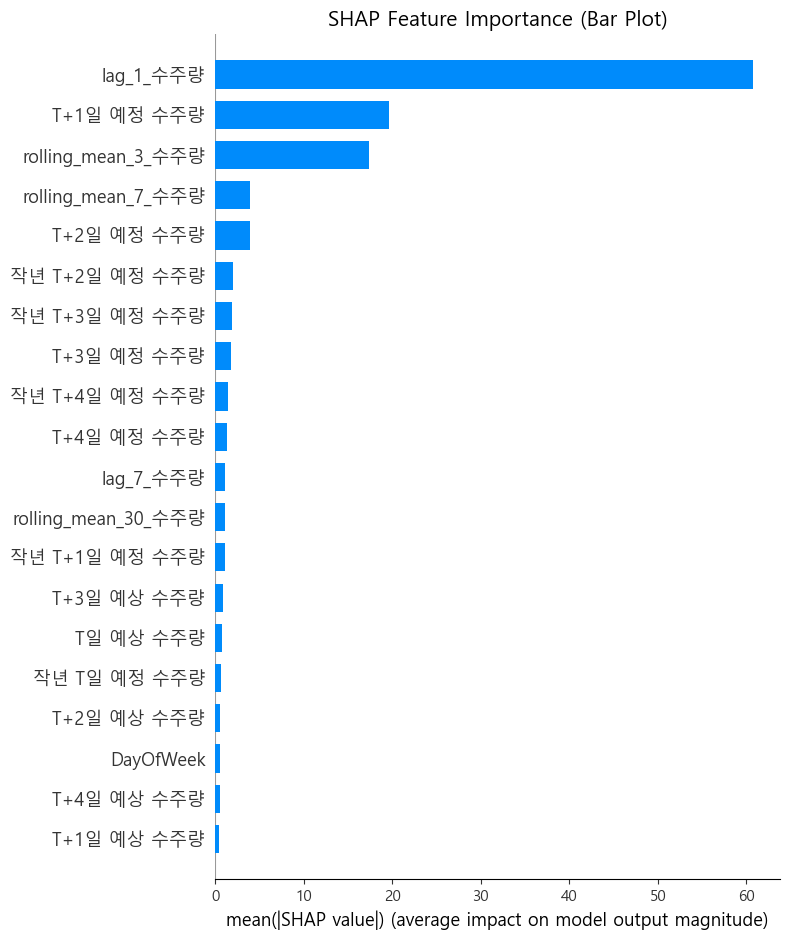

   (이 플롯은 각 피처의 SHAP 값의 절대값 평균을 보여줍니다.)

3.3 SHAP Summary Plot 시각화...


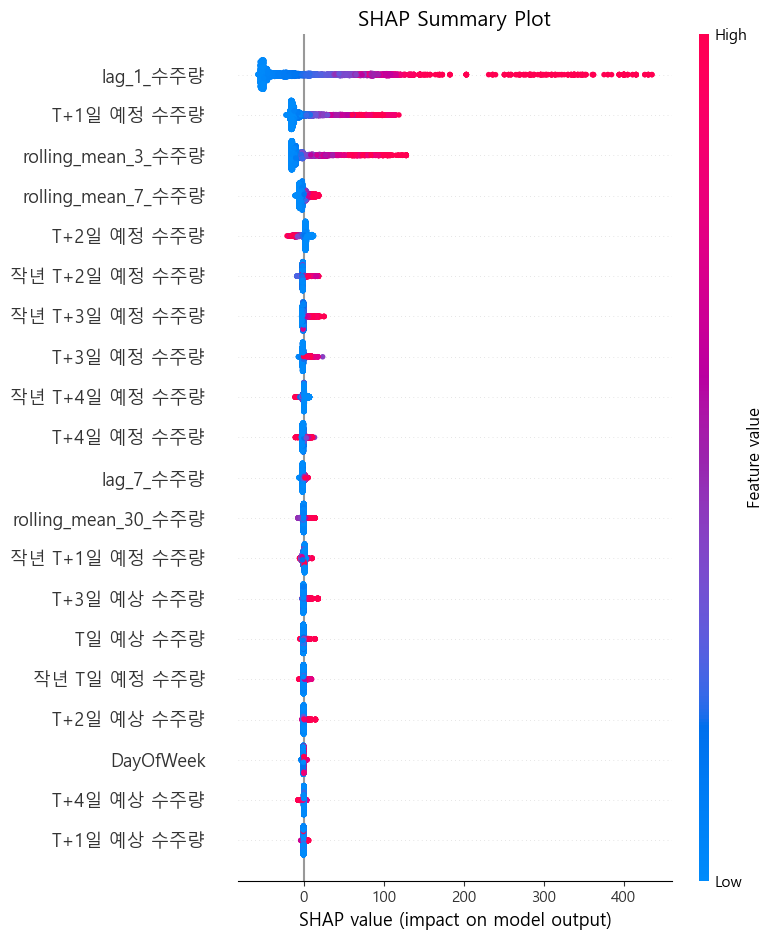

   (이 플롯은 각 피처가 예측에 미치는 영향의 크기와 방향을 보여줍니다.)
   - 빨간색: 피처 값이 높을 때 예측값 상승
   - 파란색: 피처 값이 낮을 때 예측값 상승
   - 가로축: SHAP 값 (예측값에 대한 기여도)
   - 세로축: 피처

3.4 특정 예측에 대한 지역적 피처 설명 (Force Plot)...
   테스트 세트의 1번째 샘플에 대한 Force Plot:


   (Force Plot은 1번째 예측값이 평균 예측값에서 어떻게 벗어났는지 각 피처의 기여도를 보여줍니다.)

3.5 개별 피처의 예측 영향 시각화 (Dependency Plot)...
   - 'lag_1_수주량' 피처에 대한 Dependency Plot:


<Figure size 800x600 with 0 Axes>

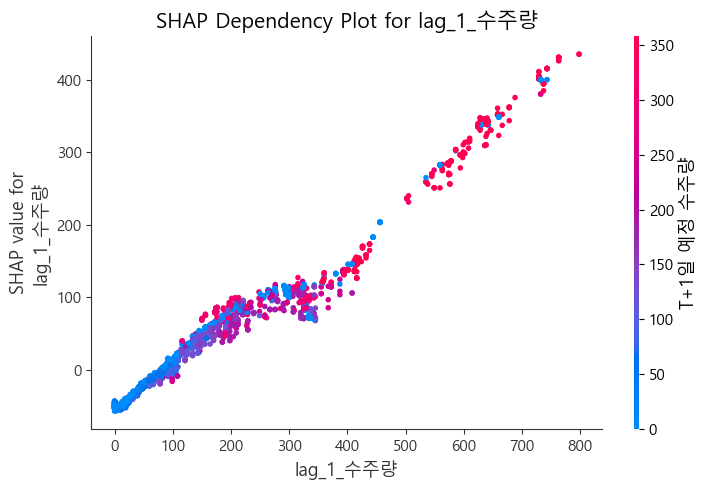

     (이 플롯은 'lag_1_수주량' 피처 값이 변함에 따라 예측값이 어떻게 변하고, 다른 피처와 어떻게 상호작용하는지 보여줍니다.)
   - 'T+1일 예정 수주량' 피처에 대한 Dependency Plot:


<Figure size 800x600 with 0 Axes>

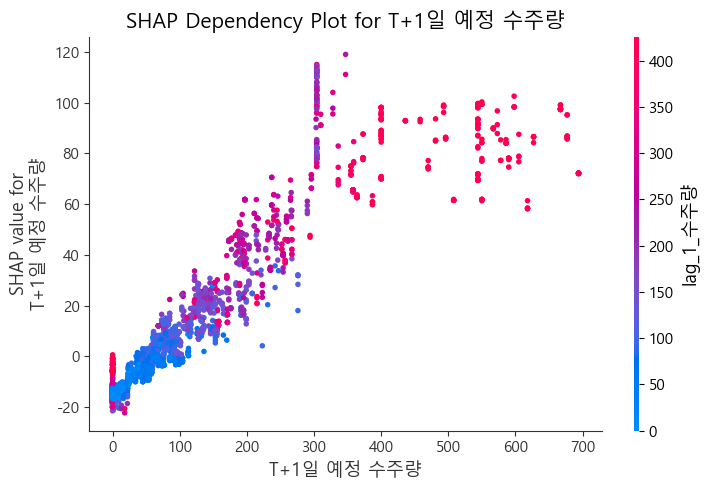

     (이 플롯은 'T+1일 예정 수주량' 피처 값이 변함에 따라 예측값이 어떻게 변하고, 다른 피처와 어떻게 상호작용하는지 보여줍니다.)
   - 'rolling_mean_3_수주량' 피처에 대한 Dependency Plot:


<Figure size 800x600 with 0 Axes>

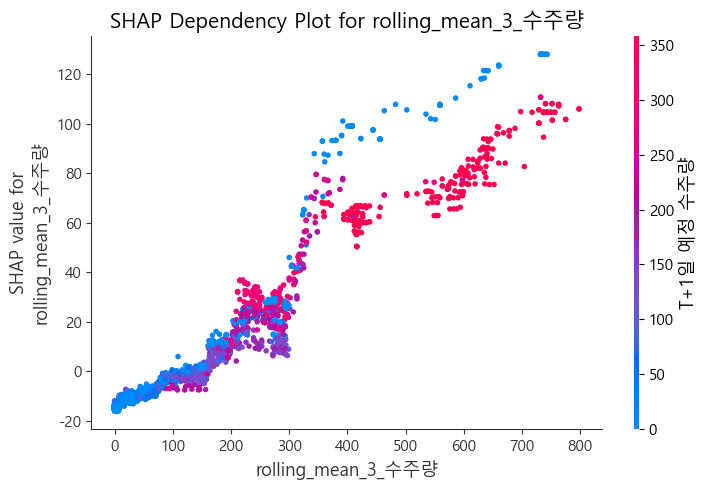

     (이 플롯은 'rolling_mean_3_수주량' 피처 값이 변함에 따라 예측값이 어떻게 변하고, 다른 피처와 어떻게 상호작용하는지 보여줍니다.)

--- [SHAP 분석 완료] ---


In [20]:
# %% [markdown]
# ## 3. SHAP (SHapley Additive exPlanations) 분석
# - 학습된 LightGBM 모델의 피처 중요도를 SHAP 값을 통해 분석합니다.
# - 전체 피처의 전역적 중요도 및 특정 예측에 대한 지역적 설명을 시각화합니다.

# %%
print("\n--- [3. SHAP 분석 시작] ---")

if 'final_model' not in locals() or final_model is None:
    print("🚨 'final_model'이 존재하지 않습니다. 이전 Optuna 튜닝 단계를 먼저 실행해주세요.")
elif 'X_test' not in locals() or X_test is None:
    print("🚨 'X_test' 데이터가 존재하지 않습니다. 이전 Optuna 튜닝 단계를 먼저 실행해주세요.")
else:
    print("3.1 SHAP Explainer 생성 및 SHAP 값 계산...")
    # LightGBM 모델에 대한 SHAP Explainer 생성
    explainer = shap.TreeExplainer(final_model, X_train)

    # 테스트 세트에 대한 SHAP 값 계산
    shap_values = explainer.shap_values(X_test)
    print("   SHAP 값 계산 완료.")

    # --- 3.2 전역적 피처 중요도 분석 (Global Feature Importance) ---

    # 1) Bar Plot으로 피처 중요도 시각화
    print("\n3.2 전역적 피처 중요도 (Global Feature Importance) 시각화 (Bar Plot)...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Bar Plot)', fontsize=15)
    plt.tight_layout()
    plt.show()
    print("   (이 플롯은 각 피처의 SHAP 값의 절대값 평균을 보여줍니다.)")

    # 2) Summary Plot으로 피처 영향 방향 시각화
    print("\n3.3 SHAP Summary Plot 시각화...")
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot', fontsize=15)
    plt.tight_layout()
    plt.show()
    print("   (이 플롯은 각 피처가 예측에 미치는 영향의 크기와 방향을 보여줍니다.)")
    print("   - 빨간색: 피처 값이 높을 때 예측값 상승")
    print("   - 파란색: 피처 값이 낮을 때 예측값 상승")
    print("   - 가로축: SHAP 값 (예측값에 대한 기여도)")
    print("   - 세로축: 피처")


    # --- 3.4 지역적 피처 설명 분석 (Local Explanation) ---
    print("\n3.4 특정 예측에 대한 지역적 피처 설명 (Force Plot)...")
    
    # 예시: 테스트 세트의 첫 번째 샘플에 대한 예측 설명
    sample_idx = 0 
    print(f"   테스트 세트의 {sample_idx+1}번째 샘플에 대한 Force Plot:")
    
    # base_value는 모델의 평균 예측값
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value
    
    # force plot (JavaScript 렌더링이 필요하므로 웹 환경에서 잘 보임)
    shap.initjs() # Jupyter Notebook/Lab 환경에서 실행 시 필요
    
    # 하나의 샘플에 대한 Force Plot
    display(shap.force_plot(base_value, shap_values[sample_idx], X_test.iloc[sample_idx]))
    print(f"   (Force Plot은 {sample_idx+1}번째 예측값이 평균 예측값에서 어떻게 벗어났는지 각 피처의 기여도를 보여줍니다.)")

    # --- 3.5 개별 피처의 의존성 플롯 (Dependency Plot) ---
    print("\n3.5 개별 피처의 예측 영향 시각화 (Dependency Plot)...")

    # 가장 중요한 피처 3개에 대한 Dependency Plot
    current_shap_values = shap_values[0] if isinstance(shap_values, list) else shap_values
    mean_abs_shap_values = np.abs(current_shap_values).mean(axis=0)
    top_features_indices = mean_abs_shap_values.argsort()[-3:][::-1] # 상위 3개 피처 인덱스
    top_features_names = X_test.columns[top_features_indices]

    for feature in top_features_names:
        print(f"   - '{feature}' 피처에 대한 Dependency Plot:")
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, current_shap_values, X_test, interaction_index="auto", show=False)
        plt.title(f'SHAP Dependency Plot for {feature}', fontsize=15)
        plt.tight_layout()
        plt.show()
        print(f"     (이 플롯은 '{feature}' 피처 값이 변함에 따라 예측값이 어떻게 변하고, 다른 피처와 어떻게 상호작용하는지 보여줍니다.)")

    print("\n--- [SHAP 분석 완료] ---")